# Interactive hypothesis testing

If you need to test a hypothesis interactively along multiple dimensions or their combinations, check out the example below that demonstrates how this can be achieved with [atoti](https://docs.atoti.io).

atoti provides a python interface to define custom aggregation functions - we will look at an example on implementing a [paired t-test](https://en.wikipedia.org/wiki/Student's_t-test#Paired_samples) as an aggregation function. Plus, it provides an interface to create dashboards that can be shared with team members.

<img src="./app-preview.gif" alt="Interactive app preview" width="70%" style="display:block;margin-left: auto;margin-right: auto;">

In this notebook we will be studying the impact of certain anti-anxiety medicine as well as a person’s mood on **memory recall ability** - based on a dataset from a kaggle user submission - [Islanders data](https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data): 

- Dataset contains observations on treatment with Alprazolam and Triazolam, as well as Sugar (in the control group) - see column **Drug** below,
- Trials has been collected for different dosages - see column **Dosage**
- Participants were primed with happy and sad memories ten minutes before the memory test - see column **Happy_Sad_group** as it is believed that a person's mood may impact memory recall.
- Memory scores represent response time, i.e. how long it takes to finish the memory test. Higher Memory scores means the ability actually reduces

![Experiment schema](./experiment-schema.png)

We will implement measures that evaluate the effect of drugs onto memory recall and visualize the result returning "H0 rejected" if data provides evidence that the average response time increases after the treatment. 

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from scipy.stats import norm, t

In [2]:
import atoti as tt

Welcome to atoti 0.4.3!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Raw data

In [3]:
# Example data is taken from kaggle user submission:
# https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data
# The example was slightly pre-processed for convenience.
df = pd.read_csv("https://data.atoti.io/notebooks/drug-efficacy/Islander_data.csv")
df.sample(5)

,Patient_Id,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Before or After,MemoryScores
55,Patient_55,Daichi,Gonzalez,68,Happy,3,Alprazolam,Before,41.9
219,Patient_21,Ava,Takahashi,31,Happy,1,Alprazolam,After,73.3
288,Patient_90,Ignacio,Carrasco,46,Happy,2,Sugar,After,65.4
192,Patient_192,Naoto,Lopez,39,Happy,3,Triazolam,Before,50.8
162,Patient_162,Cristobal,Durand,25,Sad,2,Triazolam,Before,54.6


## STEP 1: EDA

In [4]:
ProfileReport(df)

EDA shows that the cardinality of the ***fisrt_name*** and ***last_name*** columns is less than the one of the ***patient_Id*** column.

To avoid any bias on the latter statistical analysis, we should make sure tha each patient (Patient_Id) involved is well unique, and appears exactly twice in the data: one entry before receiving a treatment, and one entry after.

If not, it will imply to process the data (maybe filter ?) in order to get a table with unique patients.

In [5]:
df_groups = (
    pd.DataFrame(
        df.groupby(
            ["last_name", "first_name", "age", "Happy_Sad_group", "Dosage", "Drug"]
        )["first_name"].count()
    )
    .rename(columns={"first_name": "count"})
    .sort_values(["last_name", "first_name"])
    .reset_index()
)
df_groups.head(10)

,last_name,first_name,age,Happy_Sad_group,Dosage,Drug,count
0,Bernard,Anna,62,Happy,2,Alprazolam,2
1,Bernard,Karin,33,Sad,1,Sugar,2
2,Bernard,Ross,37,Sad,1,Triazolam,2
3,Carrasco,Adam,35,Sad,3,Sugar,2
4,Carrasco,Ami,26,Happy,1,Sugar,2
5,Carrasco,Amy,38,Happy,3,Triazolam,2
6,Carrasco,Ayaka,37,Happy,3,Sugar,2
7,Carrasco,Bastian,25,Happy,1,Alprazolam,2
8,Carrasco,Bastian,27,Happy,1,Triazolam,2
9,Carrasco,Camila,54,Happy,3,Alprazolam,2


In [6]:
df_groups["count"].value_counts()

2    198
Name: count, dtype: int64

**The table above shows that all patient are well unique and appear exactly twice. Which will imply no further data processing for the latter analysis!**

## STEP 2: Normality check

Here, we  will assess wether the data are normally distributed or not. It will then lead our choice of the statistical test to use for the latter analysis.

In [7]:
def create_QQ_plots(data, num_cols=2):
    """
    Creates Q-Q plots corresponding to series of data.
    These plots allow to check normality or not of the data.

    :num_cols: number of plots per row
    :param data: dictionary of arrays corresponding to the data series
    :return: Q-Q plots associated to the data
    """

    num_plots = len(data)
    num_rows = num_plots / num_cols
    if num_rows > int(num_rows):
        num_rows = int(num_rows) + 1
    else:
        num_rows = int(num_rows)

    left = -2.0  # x coordinate for text insert

    if num_cols == 1:
        fig = plt.figure(figsize=(15, 20))
    else:
        fig = plt.figure(figsize=(10 * num_cols, 5 * num_rows))

    for i, plot_name in enumerate(data.keys()):
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        sm.graphics.qqplot(data[plot_name], line="s", ax=ax)
        top = ax.get_ylim()[1] * 0.95
        txt = ax.text(
            left,
            top,
            plot_name + " treatment:\n\nMemory score difference (before - after)",
            verticalalignment="top",
        )
        txt.set_bbox(dict(facecolor="k", alpha=0.1))

    fig.tight_layout()
    plt.gcf()

We plot the Q-Q plots corresponding to the comparison of the quantiles from our data (Y-axis) with the theoritical quantiles from normal distribution (X-axis).

In [8]:
data = {}

df_before = df[df["Before or After"] == "Before"].sort_values("Patient_Id")
df_before = df_before.reset_index(drop=True)

df_after = df[df["Before or After"] == "After"].sort_values("Patient_Id")
df_after = df_after.reset_index(drop=True)

df_diff = df_before.copy()
df_diff.drop(columns=["Before or After", "MemoryScores"], inplace=True)
df_diff["MemoryScoresDiff"] = df_before["MemoryScores"] - df_after["MemoryScores"]

df_diff.head()

,Patient_Id,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,MemoryScoresDiff
0,Patient_0,Bastian,Carrasco,25,Happy,1,Alprazolam,2.3
1,Patient_1,Evan,Carrasco,52,Sad,1,Alprazolam,0.9
2,Patient_10,Maximiliano,Durand,63,Sad,1,Alprazolam,-12.0
3,Patient_100,Carla,Kennedy,34,Sad,2,Sugar,-5.0
4,Patient_101,Alexia,Lopez,32,Sad,2,Sugar,1.3


The following plots represent the Q-Q plots of the deviation of the memory scores following treatments (memory scores after - memory scores before).

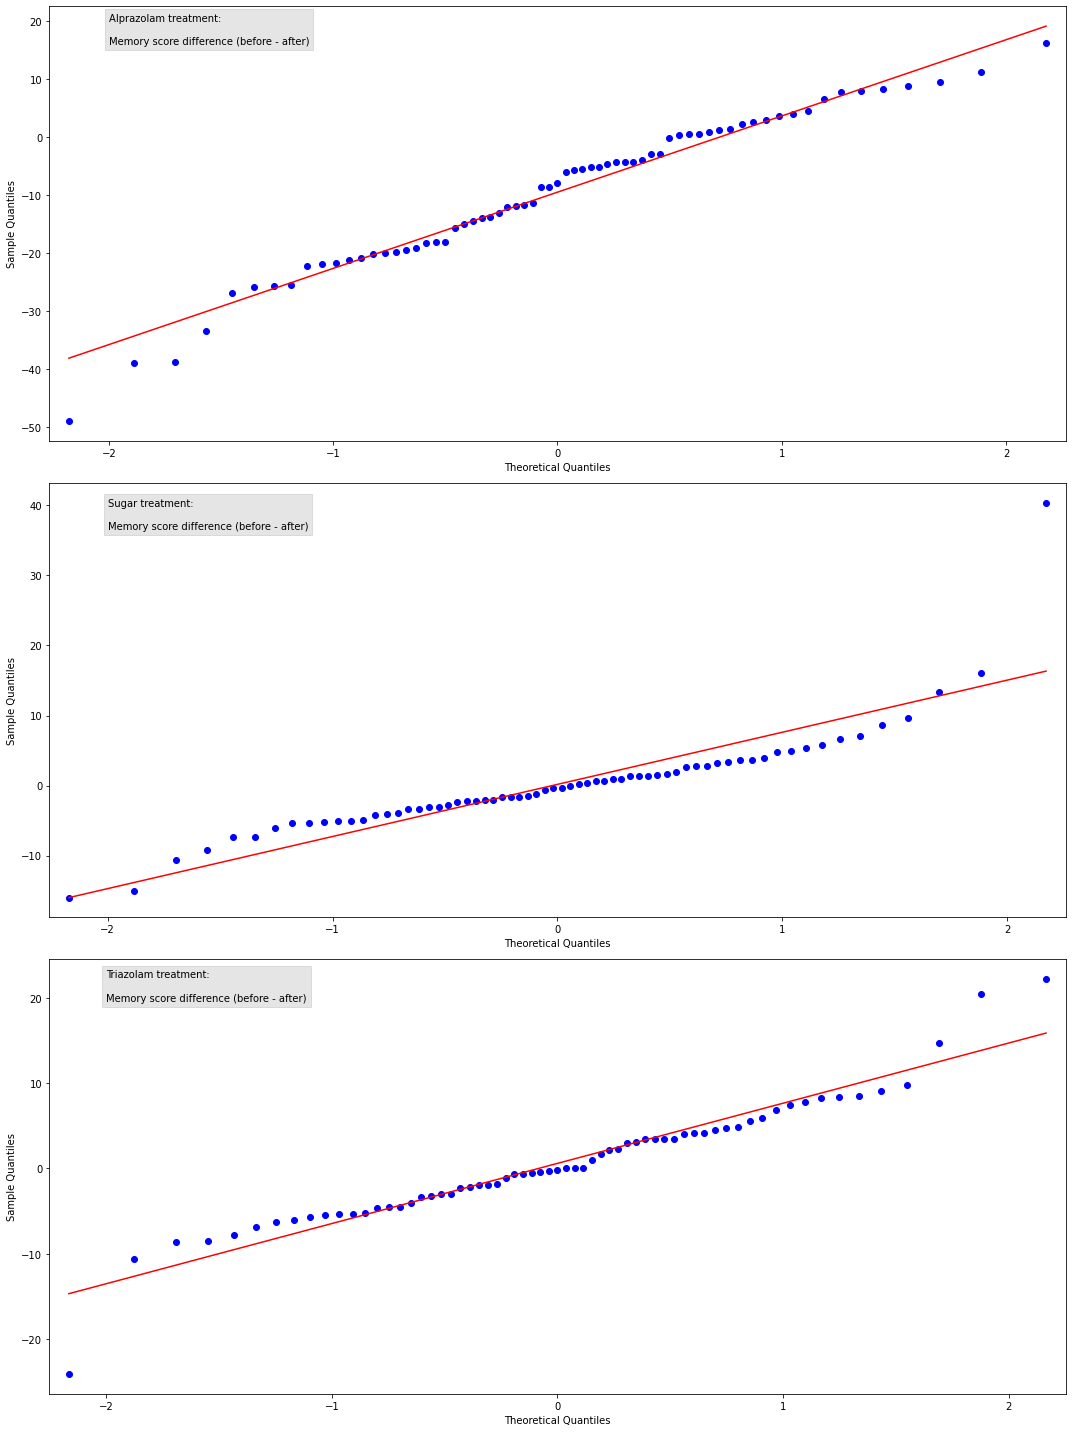

In [9]:
data = {}

for drug in df["Drug"].unique():
    data[drug] = df_diff[df_diff["Drug"] == drug]["MemoryScoresDiff"]

create_QQ_plots(data, num_cols=1)

The plots here above show that we can consider that the **differences of memory score after and before treatments are normally distributed.**

In fact, in each plot we can see that the quantiles from our sample (in blue) are aligned with the theoritical ones from the normal distribution (in red). However, we can observe a few outliers in each of these distributions (points at the tails).

Consequently, **we could use a t-Test to compare the scores before and after each treatment.** For more robustness of the t-test, we should consider **removing the outliers observations**.

## STEP 3: Atoti

## Launching atoti app

In [10]:
# creating a session - it spins up an in-memory database - similar to Apache Spark - ready to slice’n’dice your big data set.
# In addition to that, it launches a dashboarding Tableau-like web-app
from atoti.config import create_config

config = create_config(metadata_db="./metadata.db")
session = tt.create_session(config=config)

# loading initial dataset
observations_datastore = session.read_pandas(
    df, keys=["Patient_Id", "Before or After"], store_name="Observations"
)

# creating a cube -
cube = session.create_cube(observations_datastore)

## URL of atoti app

The following cell displays URL of the atoti app:

In [11]:
session.url

'http://localhost:43865'

In [12]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Inline data visualization

By running the next cell, we embed a data visualization widget - to slice and dice data inside the notebook.

In [13]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Refining the application

In [14]:
# Quick access to manage hierarchies, levels and measures
h = cube.hierarchies
l = cube.levels
m = cube.measures

# Explore the hierarchies and measures created in the cube
cube

In [15]:
# Sorting the hierarchy, so that the Before measurements show first:
l["Before or After"].comparator = tt.comparator.DESC

# This cell is hiding undesired metrics created by default.
# To create a cube without any default metrics, create_cube need to be used with parameter mode = `no_measures`
m["MemoryScores.SUM"].visible = False

# Adding attributes

We are going to group the observations by age. To achieve that, let's create and upload a **age to group mapping** into a separate data store:

In [16]:
age_groups_store = session.read_pandas(
    pd.DataFrame(
        data=[("0-25Y", i) for i in range(25)]
        + [("25Y - 40Y", i) for i in range(25, 40)]
        + [("40Y - 55Y", i) for i in range(40, 55)]
        + [("55Y+", i) for i in range(55, 100)],
        columns=["age group", "age"],
    ),
    keys=["age"],
    store_name="Age Groups",
)

observations_datastore.join(age_groups_store)

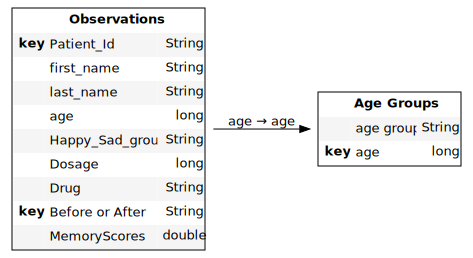

In [17]:
cube.schema

We will start using this grouping in the following cell.

In [18]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

From the following visualization we can tell, that on average:

-    for the Drug **"Triazolam"** memory scores **did not materially increase** in all age groups,
-    for the Drug **"Alprazolam"** memory response times **increased in all the age groups**, with a bigger impact in group 25Y-50Y,
-    for the Drug **"Sugar"** the scores **fluctuated**, it seems to be no significant variation on every groups.

In [19]:
cube.visualize("Average memory score by drug")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Slice-and-dice basic statistics

In [20]:
m["Mean"] = tt.agg.mean(observations_datastore["MemoryScores"])
m["Std"] = tt.agg.std(observations_datastore["MemoryScores"])
m["Min"] = tt.agg.min(observations_datastore["MemoryScores"])
m["Max"] = tt.agg.max(observations_datastore["MemoryScores"])
m["25%"] = tt.agg.quantile(observations_datastore["MemoryScores"], 0.25)
m["50%"] = tt.agg.quantile(observations_datastore["MemoryScores"], 0.50)
m["75%"] = tt.agg.quantile(observations_datastore["MemoryScores"], 0.75)

We can now slice-and-dice those statistics using any attribute available in the data.

This is an example, where the Happy or Sad field has been put onto the columns. Every time we bring an additional attribute into the view, the statistics - such averages, standard deviation and quantiles - are recomputed from the raw data.

In [21]:
cube.visualize("Basic statistics slice-and-dice")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

The statistics in the table here above seem to show that sad people tend to have a higher memory responsive time.

Let's also set up measures to interactively evaluate left and right boundaries of the 95% [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval).

In this case we are creating a measure on top of the existing measures - "Mean" and "Std" - that we have just defined above.

In [22]:
alpha = 0.05

m["95% point"] = norm.ppf(1 - alpha / 2.0)
m["Z confidence left"] = m["Mean"] - m["95% point"] * m["Std"]
m["Z confidence right"] = m["Mean"] + m["95% point"] * m["Std"]

We have just created the metrics to visualize confidence intervals interactively. The "After" intervals are wider and include the "Before" intervals, so it's difficult to say if the treatment has increased the memory scores. Let's run a statistical test to check that - in the next section.

In [23]:
cube.visualize("Interactive confidence intervals")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Paired t-test

Let's see how a paired t-test can be applied in atoti.

As a refresher, a paired t-test is one of the [statistical hypothesis tests](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) that can help testing a medication effect, given the before and after measurements. We will check that the data provides evidence that will allow us to reject the [null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis):


# - H0: on average, the memory scores before treatment is egual or less than after, 

- H0: on average, there's no difference in the memory scores before and after treatment,
- H1: on average, the memory score before the treatment is bigger (response time longer) than after, 

Or:

- H0: mean difference of memory scores is equal to or less than 0, mu <= 0
- H1: mean difference of memory scores between after and before measurements is above 0, mu>0.


Firstly, we need to compute t-statistic for the differences between memory scores after and before treatment, the statistic is defined as per the formula:

$$t_{statistic} = \frac{\bar{x}}{s/\sqrt{n}}$$

where 
- $\bar{x}$: the mean value of the memory score differences 
- $n$: the number of observations
- $s$: standard deviation of the memory score differences

We'd need to provide mean differences, stdev of differences and the number of differences (patients) participated in the test.

Let's create a measure for the difference. Let's use atoti `.filter` function to create average memory scores for the "Before" and "After" measurements, and then taking their difference.

In [24]:
m["MemoryScoresAfter.Mean"] = tt.filter(
    m["MemoryScores.MEAN"], l["Before or After"] == "After"
)
m["MemoryScoresBefore.Mean"] = tt.filter(
    m["MemoryScores.MEAN"], l["Before or After"] == "Before"
)

m["Diff.Mean"] = m["MemoryScoresAfter.Mean"] - m["MemoryScoresBefore.Mean"]
m["Diff.Mean"].formatter = "DOUBLE[#,##0.00]"

In [25]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

In [26]:
# Computing standard deviation of differences:
m["Diff.Std"] = tt.agg.std(m["Diff.Mean"], scope=tt.scope.origin(l["Patient_Id"]))

# Number of patients observed - each patient has 2 records, one for before and another for after
m["Number of observations"] = tt.agg.count_distinct(
    observations_datastore["Patient_Id"]
)

# Computing the t-statistic per formula above:
m["t-statistic"] = m["Diff.Mean"] / (
    m["Diff.Std"] / tt.sqrt(m["Number of observations"])
)
m["t-statistic"].formatter = "DOUBLE[0.00]"

We will be comparing the `t-statistic` to the right tail _critical value_, and if it's above the critical value, we will conclude that the data provides the evidence to reject the null hypothesis. Let's load 95% critical values for different [degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics)) into the cube.

![t-test table](./t-test-table.jpg)

Now, depending on the number of observations for each cell, we will pick a critical value and visualize it as a measure:

In [27]:
# Loading a "table" of critical values, 101 values in total.
# For experiments with more than 101 degrees of freedom, we approximate the critical value, for 95% confidence - with value 1.96.
# m["t-critical values list"] = [t.ppf(0.95, d) for d in range(1, 101)] + [1.645]
m["t-critical values list"] = [t.ppf(0.95, d) for d in range(1, 101)] + [1.96]

# Computing degrees of freedom as the number of observations minus 1:
degrees_of_freedom = m["Number of observations"] - 1

# Shifting the df by -1 to use as an index and look up critical value from the list:
df_as_index = degrees_of_freedom - 1

# If there're too many observations (more than 101), we'll cap it:
capped_df_as_index = tt.where(df_as_index > 100, 100, df_as_index)

# This measure will be looking up a critical value for the current scope:
m["t-critical"] = m["t-critical values list"][capped_df_as_index]

This measure is displaying whether the observed t-statistics is to the right from the critical value, i.e. there's evidence that H0 can be rejected. It will visualize the result of t-test every time we expand and collapse data:

In [28]:
m["Test Result"] = tt.where(
    m["t-statistic"] > m["t-critical"], "H0 rejected", "Can't reject H0"
)

In the next session we'll see how to use the measure created above to visualize the test result.

# Interactive hypothesis testing

Now we can experiment and re-group our data and apply the test interactively:

- **"H0 rejected"** will mean that the data provides evidence that mean difference is not 0, meaning, there's a statistically significant impact of treatment onto the memory scores.
- **"Can't reject H0"** will mean that t-statistic is smaller than the critical value, and we can't reject the null hypothesis.

We expand by the name of the drug, then by dosages, then by patient "Happy/Sad" group, and this is what we found out:

- there's an evidence that **Drug Aprazolam** had impact on the memory scores (response time), while Sugar and Triazolam did not, 
- when we break down the Drug Aprazolam observations **by dosage** -  we notice that only the dosages 1 and 2 are statistically significant, 
- if we further expand to "Happy/Sad" group, and for the "Happy" patients only the higher dosage impacted the memory score.

In [29]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Quick simulation

Let's make a quick comparison of the test results under the 95%, 97.5%, 99% confidence levels by loading new critical values into simulations. As a reminder, we've been using the 95% critical values so far.

In [30]:
# creating a new simulation to override critical values, and giving a name to the initial values
confidence_levels = cube.setup_simulation(
    "Confidence Levels", replace=[m["t-critical values list"]], base_scenario="95%"
).scenarios
# creating new critical values based on 0.975 and 0.99 confidence levels
# confidence_levels["97.5%"] = [t.ppf(0.975, d) for d in range(1, 101)] + [1.960]
# confidence_levels["99%"] = [t.ppf(0.99, d) for d in range(1, 101)] + [2.326]
confidence_levels["97.5%"] = [t.ppf(0.975, d) for d in range(1, 101)] + [2.241]
confidence_levels["99%"] = [t.ppf(0.99, d) for d in range(1, 101)] + [2.576]

Let's expand Test results for Sugar and we'll see that the hypothesis is rejected for dosage 1 under the 95% and 97.5% confidence levels - implying that memory reponse time increases for patients taking low dosage of sugar (placebo). Most probably we are making Type I error - false positive result. Increasing the confidence level helps to reduce the probability of Type I error, in our case, H0 is not rejected for Sugar with 99% confidence level.

In [31]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Alternative data sets

Let's imagine that we obtained memory scores data using an alternative methodology, and want to compare the test results side-by-side with the original approach.

In [32]:
observations_datastore.scenarios["Multicenter study data"].load_csv(
    "s3://data.atoti.io/notebooks/drug-efficacy/Multi_center_study_data.csv"
)

In [33]:
cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

# Conclusion

In this notebook we have configured an analytical application for **exploratory data analysis**, that allows us to **interactively browse** the data and re-compute statistics, such as mean, stdev, etc, as well as more complex functions - such as hypothesis test metrics - **on-the-fly**. Even though the example has a handful of observation, atoti's backend is designed to handle big data. Please refer to this white page is you want to learn about the [technology](https://activeviam.com/images/pdf/white-papers/ActiveViam_Technical_White_Paper_-_ActivePivot.pdf) on atoti's backend.

The application comes with a **user interface**, so the results of the analysis can be visualized in a dashboard and presented to users:


In [34]:
session.url + "/#/dashboard/3f7"

'http://localhost:43865/#/dashboard/3f7'